# Import Libraries



In [1]:
!pip install lazypredict

In [9]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.mixture import BayesianGaussianMixture
from tqdm import tqdm

#####
from lazypredict.Supervised import LazyClassifier



# Load and Prepare Dataset

load features , csv files , Images

**Download and unzip Dataset**

In [2]:
!gdown 1tKCABslGetwXq9pp9pKUCHIjBYNlpeaW

Downloading...
From: https://drive.google.com/uc?id=1tKCABslGetwXq9pp9pKUCHIjBYNlpeaW
To: /content/dataset_ml.zip
100% 2.23G/2.23G [00:27<00:00, 80.7MB/s]


In [3]:
!unzip -qq "./dataset_ml.zip"

**Read Data**

In [10]:
real_folder = './real'
fake_folder = './fake'

# Read all files in the real and fake folders
real_files = [os.path.join(real_folder, file) for file in os.listdir(real_folder)]
fake_files = [os.path.join(fake_folder, file) for file in os.listdir(fake_folder)]

# Create the dataset
dataset = [(file, 'Real') for file in real_files] + [(file, 'Fake') for file in fake_files]

# Shuffle the dataset
random.shuffle(dataset)

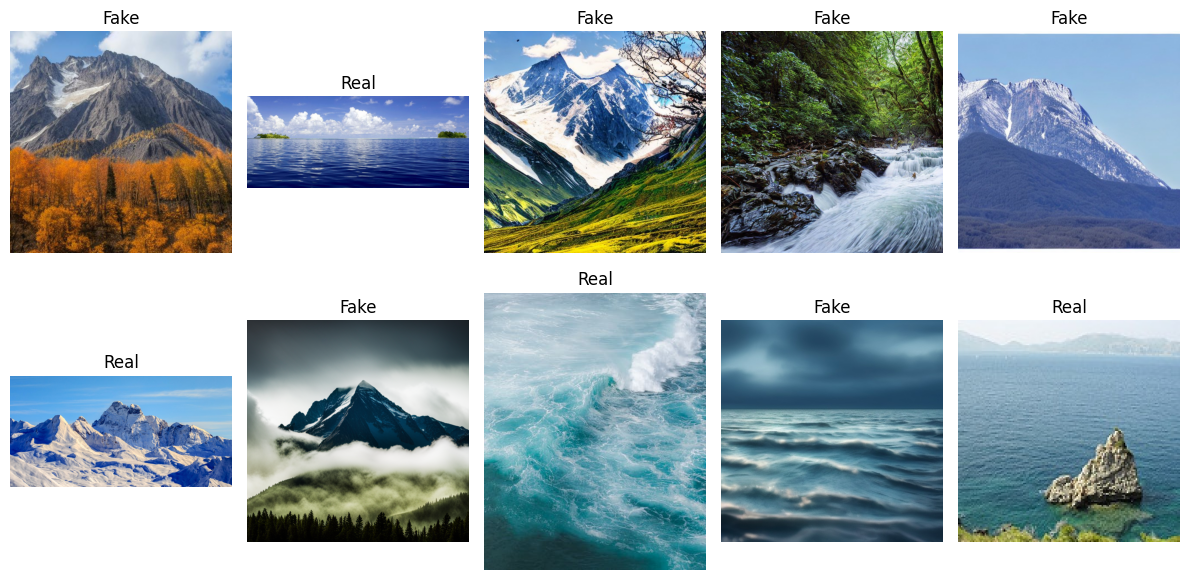

In [11]:
# Display 10 real and fake images randomly
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i in range(10):
    file_path, label = dataset[i]

    # Read the image using cv2
    image = cv2.imread(file_path)

    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(label)

plt.tight_layout()
plt.show()

# Preprocess and FeatureExtracting

for preprocess we resize images
for FeatureExtracting we use : HOG , LBP , ColorHist , ..

In [12]:
# Define Feature Extracting functions

def extract_hog_features(image):
    hog_features = feature.hog(image, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys')
    return hog_features


def extract_lbp_features(image):
    lbp = feature.local_binary_pattern(image, 24, 8, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 27), range=(0, 26))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-7)
    return lbp_hist

def extract_colorhist_features(image):
    color_hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    color_hist = cv2.normalize(color_hist, color_hist).flatten()
    return color_hist

In [13]:
# Set the batch size
batch_size = 100

# Initialize empty lists to store features and labels
features = []
labels = []

# Process images in batches to avoid memory issues
with tqdm(total=len(dataset), desc='Extracting features') as pbar:
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i+batch_size]
        batch_features = []
        batch_labels = []

        for file_path, label in batch:
            try:
                image = cv2.imread(file_path)

                # Check if image is successfully read
                if image is None:
                    # Skip the image and its label
                    continue

                # Resize
                resized_image = cv2.resize(image, (32, 32))

                # Convert the resized image to grayscale
                gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

                # Extract features
                hog_features = extract_hog_features(gray_image)
                lbp_features = extract_lbp_features(gray_image)
                colorhist_features = extract_colorhist_features(resized_image)

                # Combine features
                combined_features = np.concatenate((hog_features, lbp_features, colorhist_features))

                batch_features.append(combined_features)
                batch_labels.append(label)

            except Exception as e:
                print(f"Error processing image: {file_path}")
                print(f"Error message: {str(e)}")

            pbar.update(1)

        features.extend(batch_features)
        labels.extend(batch_labels)

# Convert labels to numeric format
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

# Create a DataFrame with features and labels
df = pd.DataFrame(features)
df['Label'] = numeric_labels

# Save the DataFrame as a CSV file
df.to_csv('image_features.csv', index=False)

Extracting features: 100%|█████████▉| 3417/3421 [04:12<00:00, 13.56it/s]


# Classification

**Preprocess and split**

Split data to test and train ( 80 to 20 )
prepare X_train , X_test , Y_train , Y_test

In [14]:
# Load the feature dataset and labels
df = pd.read_csv('image_features.csv')
features = df.drop('Label', axis=1).values
labels = df['Label'].values

# Identify missing values
missing_mask = np.isnan(features)

# Perform imputation or removal of rows/columns with missing values
imputer = SimpleImputer(strategy='mean')  # Example: Impute missing values with the mean
features_imputed = imputer.fit_transform(features)

# Apply feature normalization
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features_imputed)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_normalized, labels, test_size=0.2, random_state=42)

**SVM-Kernel Linear**

In [15]:
# Train the SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Predict the labels for training and testing sets
y_train_pred = svm_model.predict(X_train)
y_test_pred = svm_model.predict(X_test)

# Calculate the accuracy of the model
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the accuracy of the model
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

# Calculate the confusion matrix for the testing set
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Testing Set):")
print(confusion_matrix_test)

Training Accuracy: 0.7936333699231614
Testing Accuracy: 0.6578947368421053
Confusion Matrix (Testing Set):
[[209 119]
 [115 241]]


**SVM-Kernel RBF**

In [16]:
# Train the SVM model
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

# Predict the labels for training and testing sets
y_train_pred = svm_model.predict(X_train)
y_test_pred = svm_model.predict(X_test)

# Calculate the accuracy of the model
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the accuracy of the model
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

# Calculate the confusion matrix for the testing set
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Testing Set):")
print(confusion_matrix_test)

Training Accuracy: 0.7929015733626052
Testing Accuracy: 0.6578947368421053
Confusion Matrix (Testing Set):
[[205 123]
 [111 245]]


**Random Forrest**

In [17]:
# Train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict the labels for training and testing sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate the accuracy of the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")

# Calculate the accuracy of the model on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {test_accuracy}")

# Calculate the confusion matrix for the testing set
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Testing Set):")
print(confusion_matrix_test)

Training Accuracy: 1.0
Testing Accuracy: 0.6652046783625731
Confusion Matrix (Testing Set):
[[234  94]
 [135 221]]


# Classification on 29 Classification model
In this part we use lazy-predict package

**Load Features**

In [18]:
# Load the feature dataset and labels
df = pd.read_csv('image_features.csv')
features = df.drop('Label', axis=1).values
labels = df['Label'].values

In [19]:
# Identify missing values
missing_mask = np.isnan(features)

# Perform imputation or removal of rows/columns with missing values
imputer = SimpleImputer(strategy='mean')  # Example: Impute missing values with the mean
features_imputed = imputer.fit_transform(features)

# Apply feature normalization
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features_imputed)

In [20]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_normalized, labels, test_size=0.2, random_state=42)

In [24]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████| 29/29 [02:13<00:00,  4.60s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.71               0.71     0.71      0.71   
NuSVC                              0.69               0.69     0.69      0.69   
XGBClassifier                      0.69               0.69     0.69      0.69   
SVC                                0.69               0.69     0.69      0.69   
RandomForestClassifier             0.67               0.67     0.67      0.67   
ExtraTreesClassifier               0.66               0.66     0.66      0.66   
LogisticRegression                 0.65               0.65     0.65      0.65   
RidgeClassifier                    0.65               0.65     0.65      0.65   
RidgeClassifierCV                  0.65               0.65     0.65      0.65   
AdaBoostClassifier                 0.64               0.64     0.64      0.64   
CalibratedClassifierCV      

# Clustering

**load Data**

In [21]:
# Load the feature dataset and labels
df = pd.read_csv('image_features.csv')
features = df.drop('Label', axis=1).values
labels = df['Label'].values

# Identify missing values
missing_mask = np.isnan(features)

# Perform imputation or removal of rows/columns with missing values
imputer = SimpleImputer(strategy='mean')  # Example: Impute missing values with the mean
features_imputed = imputer.fit_transform(features)

# Apply feature normalization
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features_imputed)

**K-Means**

In [22]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(features_normalized)

In [23]:
# Determine the cluster labels based on majority vote
cluster_labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    majority_label = np.argmax(np.bincount(labels[mask]))
    cluster_labels[mask] = majority_label

# Calculate the accuracy of the clustering
accuracy = accuracy_score(labels, cluster_labels)
print(f"Accuracy of K-means Clustering: {accuracy}")

Accuracy of K-means Clustering: 0.5232660228270413
